In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import covid

data = covid.get_combined_covid_data('Sweden')
data

Country/Region Province/State       Date  Cum. Cases  Cases  Cum. Deaths  \
0           Sweden            N/A 2020-01-22           0    0.0            0   
1           Sweden            N/A 2020-01-23           0    0.0            0   
2           Sweden            N/A 2020-01-24           0    0.0            0   
3           Sweden            N/A 2020-01-25           0    0.0            0   
4           Sweden            N/A 2020-01-26           0    0.0            0   
..             ...            ...        ...         ...    ...          ...   
238         Sweden            N/A 2020-09-16       87575  230.0         5860   
239         Sweden            N/A 2020-09-17       87885  310.0         5864   
240         Sweden            N/A 2020-09-18       88237  352.0         5865   
241         Sweden            N/A 2020-09-19       88237    0.0         5865   
242         Sweden            N/A 2020-09-20       88237    0.0         5865   

     Deaths  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
..      ...  
238     9.0  
239     4.0  
240     1.0  
241     0.0  
242     0.0  

[243 rows x 7 columns]

<AxesSubplot:label='f49671dd-a0b8-42ef-952d-b6436e332b09'>

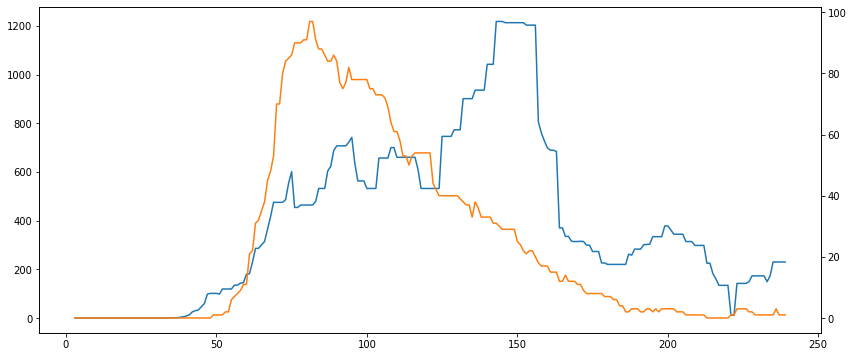

In [2]:
f,ax=plt.subplots(figsize=(14,6))
data['Cases'].rolling(window=7,center=True).median().plot(ax=ax)
data['Deaths'].rolling(window=7,center=True).median().plot(ax=ax, secondary_y=True)

In [3]:
r, p = stats.pearsonr(data['Cases'], data['Deaths'])
# Set window size to compute moving window synchrony.
r_window_size = 14
# Interpolate missing data.
df_interpolated = data[['Cases', 'Deaths']].interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['Cases'].rolling(window=r_window_size, center=True).corr(df_interpolated['Deaths'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
data[['Cases', 'Deaths']].rolling(window=7,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Counts')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Covid data and rolling window correlation")

Text(0.5, 0.98, 'Covid data and rolling window correlation')

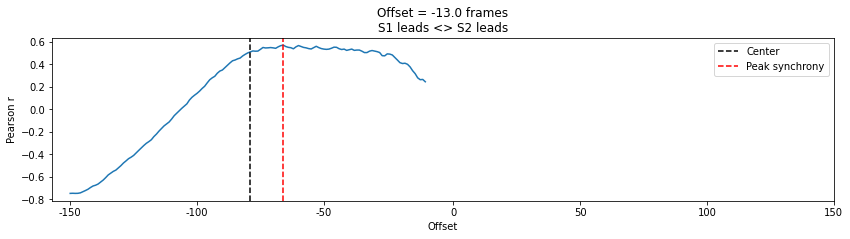

In [4]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = data['Cases']
d2 = data['Deaths']
seconds = 5
fps = 14
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads', xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()


[Text(0.5, 1.0, 'Windowed Time Lagged Cross Correlation'),
 (140.0, 175.0),
 Text(0.5, 24.0, 'Offset'),
 Text(69.0, 0.5, 'Window epochs')]

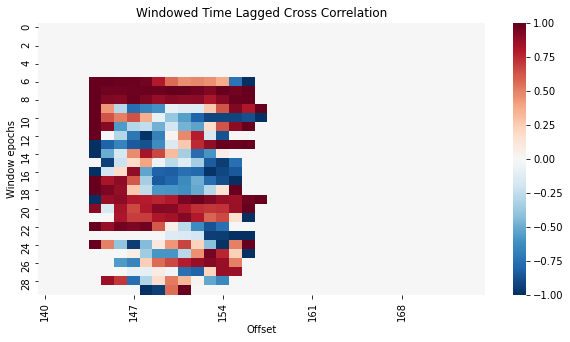

In [5]:
# Windowed time lagged cross correlation
seconds = 5
fps = 30
no_splits = 30
samples_per_split = data.shape[0]/no_splits
rss=[]
df = data[['Cases', 'Deaths']].reset_index().rolling(window=10,center=True).median()
for t in range(0, no_splits):
    d1 = df['Cases'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['Deaths'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss.fillna(0),cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation', xlim=[140,175], xlabel='Offset',ylabel='Window epochs')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);

[Text(0.5, 1.0, 'Rolling Windowed Time Lagged Cross Correlation'),
 (133.0, 189.0),
 Text(0.5, 69.0, 'Offset'),
 Text(69.0, 0.5, 'Epochs')]

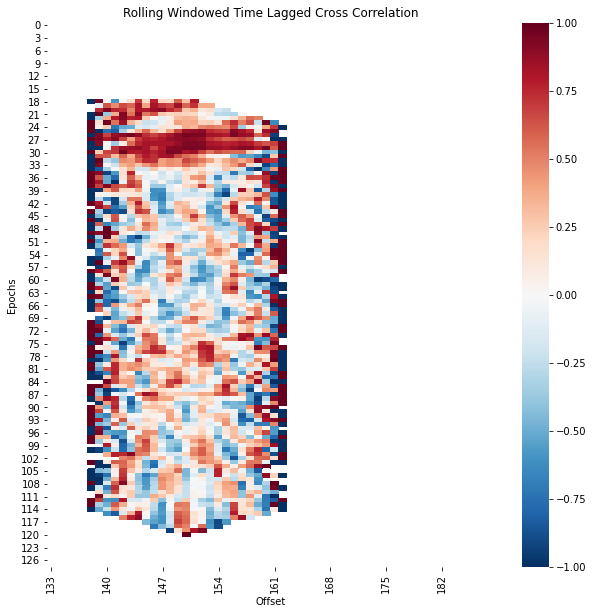

In [9]:
seconds = 5
fps = 30
window_size = 14 #samples
t_start = 0
t_end = t_start + window_size
step_size = 2
rss=[]
df = data[['Cases', 'Deaths']]
while t_end < 270:
    d1 = df['Cases'].iloc[t_start:t_end]
    d2 = df['Deaths'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[133,189], xlabel='Offset',ylabel='Epochs')
#ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
#ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);